## Описание проекта

Нам предоставлена выборка данных пользователей, их поездок и подписок сервиса аренды самокатов GoFast. На основании этой информации мы будем искать для компании точки роста. \
\
В нашем распоряжении три файла:
1) **users_go.csv** - сожержит данные пользователей

Столбцы: 
- user_id	уникальный идентификатор пользователя 
- name	имя пользователя 
- age	возраст 
- city	город 
- subscription_type	тип подписки (free, ultra)


2) **rides_go.csv** - поездки пользователей 

Столбцы:
- user_id	уникальный идентификатор пользователя
- distance	расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date   дата совершения поездки


3) **subscriptions_go.csv** - подписки 

Столбцы:
- subscription_type	тип подписки
- minute_price	стоимость одной минуты поездки по данной подписке
- start_ride_price	стоимость начала поездки
- subscription_fee	стоимость ежемесячного платежа

Важная информация, сервисом можно пользоваться:
- **без подписки** \
абонентская плата отсутствует; \
стоимость одной минуты поездки — 8 рублей; \
стоимость старта (начала поездки) — 50 рублей; 
- **с подпиской Ultra**
абонентская плата — 199 рублей в месяц; \
стоимость одной минуты поездки — 6 рублей; \
стоимость старта — бесплатно. 

Поэтому выброка наша - стратифицированная, в ней две группы пользователей - с подпиской и без подписки.


## Откроем файл с данными и изучим общую информацию.

### Импорты

In [1]:
# Сделаем все необходимые импорты
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st

### Загрузка датафреймов

In [2]:
# Загрузим предоставленные датафреймы
users_df = pd.read_csv('/datasets/users_go.csv')
rides_df = pd.read_csv('/datasets/rides_go.csv')
subscriptions_df = pd.read_csv('/datasets/subscriptions_go.csv')

### Изучим файлы

#### Пользователи

In [3]:
# Первые пять строк датафрейма
users_df.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
# C помощью метода info() посмотрим основную информацию о датафреймах
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
# Напишем функцию для вывода основных статистик набораа данных

def dataframe_information(data):
    """Функция для вывода основных статистик набора данных"""
    df_data = []
    df_cols = ['name', 'object', 'na', 'zero', 'rate', 'unique', 'neg',
               'mean', 'std', 'min', 'max', 'outliners', 'duplicates']
    # перебираем столбцы в наборе данных
    for column_name in data.columns:
        column_negative_values, column_mean, column_std, column_min, column_max, outliers = \
        None, None, None, None, None, None
        # считаем характеристики
        column_type = data[column_name].dtypes
        column_na_values = data[column_name].isna().sum()
        column_zero_values = data[column_name][data[column_name] == 0].count()
        column_na_zero_rate = (column_na_values + column_zero_values) / data.shape[0]
        column_unique_values = len(data[column_name].unique())
        if data[column_name].dtype != 'object':
            column_negative_values = data[column_name][data[column_name] < 0].count()
            column_mean = data[column_name].mean()
            column_std = data[column_name].std()
            column_min = data[column_name].min()
            column_max = data[column_name].max()
            q1 = data[column_name].quantile(0.25)
            q3 = data[column_name].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            outliers = len(data[(data[column_name] < lower_bound) | (data[column_name] > upper_bound)])
            duplicates_sum = len(data.loc[data.duplicated() > 0, column_name])

        # собираем показатели по каждому полю
        df_data.append([column_name, column_type, column_na_values,
                        column_zero_values, column_na_zero_rate, column_unique_values,
                        column_negative_values, column_mean, column_std, column_min,
                        column_max, outliers, duplicates_sum])

    # формируем набор данных
    df_res = pd.DataFrame(data = df_data, columns = df_cols)

    return df_res

In [6]:
dataframe_information(users_df)

,name,object,na,zero,rate,unique,neg,mean,std,min,max,outliners,duplicates
0,user_id,int64,0,0,0.0,1534,0.0,762.633866,443.260155,1.0,1534.0,0.0,31
1,name,object,0,0,0.0,194,NaN,NaN,NaN,NaN,NaN,NaN,31
2,age,int64,0,0,0.0,29,0.0,24.922045,4.553496,12.0,43.0,9.0,31
3,city,object,0,0,0.0,8,NaN,NaN,NaN,NaN,NaN,NaN,31
4,subscription_type,object,0,0,0.0,2,NaN,NaN,NaN,NaN,NaN,NaN,31


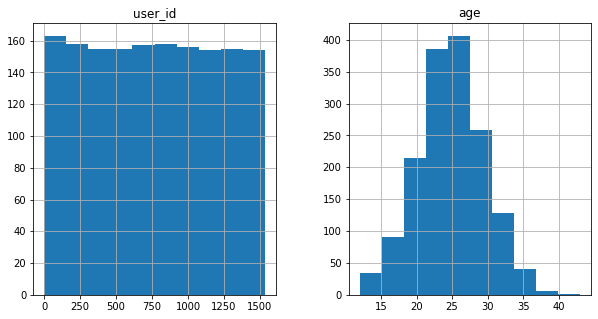

In [7]:
# Строим общую гистограмму для всех числовых столбцов таблицы.
users_df.hist(figsize=(10, 5))
plt.show()

Есть выбросы в столбце age и 31 дубликат строк.

#### Поездки

In [8]:
# Выведем первые пять строк датафрейма
rides_df.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [9]:
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [10]:
# Выведем основные статистики
dataframe_information(rides_df)

,name,object,na,zero,rate,unique,neg,mean,std,min,max,outliners,duplicates
0,user_id,int64,0,0,0.0,1534,0.0,842.869936,434.734317,1.000000,1534.000000,0.0,0
1,distance,float64,0,0,0.0,18068,0.0,3070.659976,1116.831209,0.855683,7211.007745,1036.0,0
2,duration,float64,0,0,0.0,17974,0.0,17.805011,6.091051,0.500000,40.823963,177.0,0
3,date,object,0,0,0.0,364,NaN,NaN,NaN,NaN,NaN,NaN,0


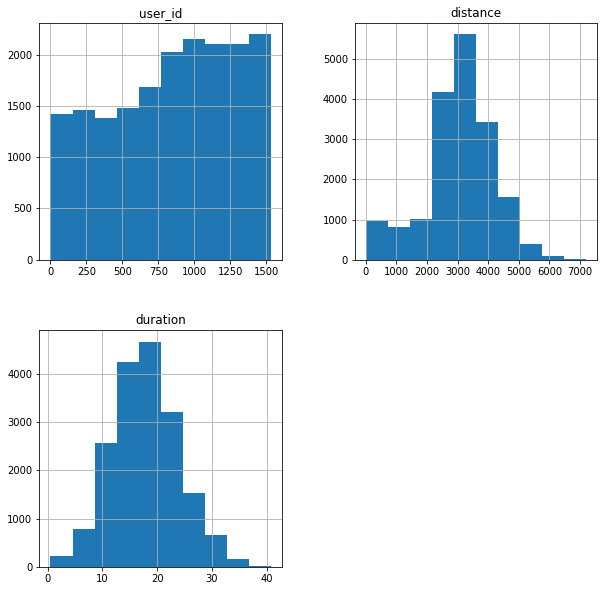

In [11]:
# Строим общую гистограмму для всех числовых столбцов таблицы.
rides_df.hist(figsize=(10, 10))
plt.show()

Есть выбросы в столбцах distance и duration.

#### Тарифы

In [12]:
# Выведем первые пять строк датафрейма
subscriptions_df.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Так как в данных всего две строчки, применять функцию вывода основных характеристик не будем, ограничимся методом info()

In [13]:
subscriptions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


### Вывод

В таблице users_df:
- 1565 строк и 5 колонок;
- есть 9 выбросов в столбце age и 31 дубликат строк. 

В таблице rides_df:
- 18068  строк и 4 колонки;
- есть значительное количество выбросов(1036) в столбце distance и 177 в столбце duration. 

В таблице subscriptions_df всего две строки - тарифы, 4 колонки, проблем нет. 

Необходимо выявить причины появления дубликатов строк в таблице users_df.
В таблицах rides_df столбцец data привести к типу данных datetime.

## Предобработка данных

В этом разделе мы подготовим данные для дальнейшего анализа, а именно:
- Приведем к формату datetime столбец date в таблце rides_df и создадим на его основании столбец с месяцем, в котором пользователь совершил поездку.
- Удалим дубликаты строк.
- Обработаем выбросы.

Датафрейм rides_df содержит большое количество выбросов, поэтому перед проведением предобработки зафиксируем количество данных, которые он содержит, чтобы в конце этого раздела сравнить количество данных в датафрейме до и после предобработки. Наша цель сохранить более 90% информации.

In [14]:
# Зафиксируем размер таблицы rides_df
rides_df_old = rides_df.shape
rides_df_old

(18068, 4)

### Удалим дубликаты

In [15]:
users_df = users_df.drop_duplicates().reset_index(drop=True)

### Приведем столбец data в таблице rides_df к формату datetime

In [16]:
# Приведение к datetime
rides_df['date'] = pd.to_datetime(rides_df['date'], format='%Y-%m-%d')

In [17]:
# Проверим результативность
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


### Добавим в таблицу rides_df столбцец month (местяц, в который была совершена поездка)

In [18]:
# Чтобы убедиться, что данные за несколько лет не склебются по месяцам, проверим, за какой период представлены данные
rides_df['date'].dt.year.value_counts()

2021    18068
Name: date, dtype: int64

In [19]:
# Добавим столбец с месяцем поездки
rides_df['month'] = rides_df['date'].dt.month

# Проверим результат
rides_df['month'] 

0         1
1         1
2         4
3         8
4         8
         ..
18063    11
18064    11
18065    11
18066    11
18067    12
Name: month, Length: 18068, dtype: int64

### Посмотрим на выбросы и аномалии в данных

#### В таблице users_df

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


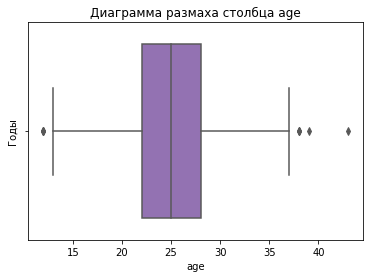

In [20]:
# Построим диаграмму размаха
sns.boxplot(users_df['age'], color='tab:purple')
plt.title(f'Диаграмма размаха столбца {"age"}')
plt.ylabel('Годы')
plt.show()

In [21]:
# Создадим функцию для отображения границ выбросов
def borders_of_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

# Отобразим границы выбросов
borders_of_outliers(users_df, 'age')

(13.0, 37.0)

Можно сделать вывод, что пользователей моложе 14 и старше 36 крайне редко арендуют самокаты.

**Выбросы в столбце duration**

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


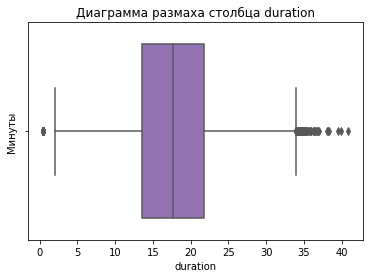

In [22]:
# Построим диаграмму размаха
sns.boxplot(rides_df['duration'], color='tab:purple')
plt.title(f'Диаграмма размаха столбца {"duration"}')
plt.ylabel('Минуты')
plt.show()

In [23]:
# Отобразим точные границы выбросов
borders_of_outliers(rides_df, 'duration')

(1.4067070934272756, 33.91565577561293)

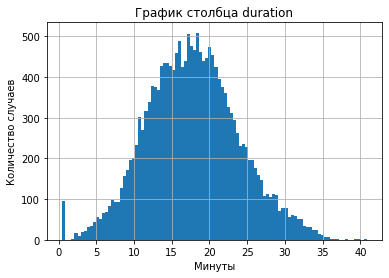

In [24]:
rides_df['duration'].hist(bins=100)
plt.title('График столбца duration')
plt.xlabel('Минуты')
plt.ylabel('Количество случаев')
plt.show()

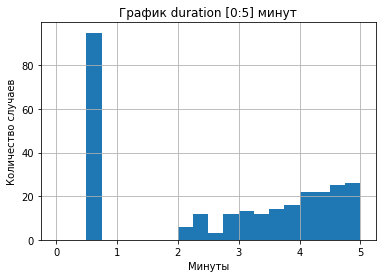

In [25]:
rides_df['duration'].hist(bins=20, range=(0, 5))
plt.title('График duration [0:5] минут')
plt.xlabel('Минуты')
plt.ylabel('Количество случаев')
plt.show()

Какое то аномальное константное значение. Посмотрим на эти случаи.

In [26]:
rides_df.query('duration < 2')

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


Видно, что поездки были длительные, посмотрим на распределение дистанций, у которых поле duration заполнено константным значением. 

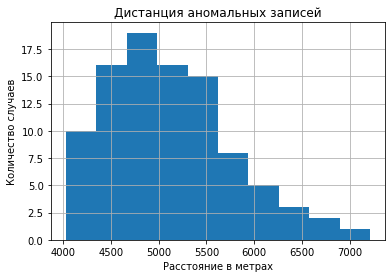

In [27]:
# Получим распределение дистанции строк с значением продолжительности поездки 0.5 минуты.
rides_df.query('duration < 2')['distance'].hist()
plt.title('Дистанция аномальных записей')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество случаев')
plt.show()

In [28]:
# Посмотрим правый хвост выбросов
rides_df.query('duration > 34')

,user_id,distance,duration,date,month
42,4,4649.488243,35.896929,2021-08-14,8
143,15,4187.621459,38.125729,2021-01-13,1
499,55,4151.081878,36.906491,2021-06-30,6
524,58,4763.920660,35.819603,2021-02-17,2
854,91,4444.579979,35.222900,2021-11-05,11
...,...,...,...,...,...
17119,1468,4744.875534,34.881139,2021-06-13,6
17235,1476,4217.871874,34.006574,2021-04-13,4
17353,1485,3807.409685,34.767689,2021-12-09,12
17684,1509,3728.895778,34.339432,2021-01-22,1


Необходимо обратить внимание программистов на искажение данных у части случаев поездок на длинные дистанции - поле duration заполнено константным значением '0.5'. Непонятна причина заполнения, но учитывая, что на общем графике нет поездок с длительностью более 40 минут, возможно такое заполнение получили более длительные поездки.\
Можно было бы заполнить их медианами подходящих диапазонов дистанции, но случаев немного (170), поэтому оставим как есть.

#### В таблице riders_df

**Выбросы в столбце distance**

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


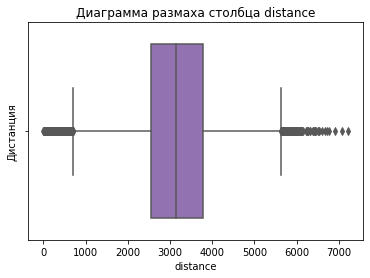

In [29]:
# Построим диаграмму размаха
sns.boxplot(rides_df['distance'], color='tab:purple')
plt.title(f'Диаграмма размаха столбца {"distance"}')
plt.ylabel('Дистанция')
plt.show()

In [30]:
# Отобразим точные границы выбросов
borders_of_outliers(rides_df, 'distance')

(693.7317969370258, 5625.717298360568)

In [31]:
# Уточним, какой процент от всего датасета составляют выбросы в этой колонке
len(rides_df.query('distance < 715 or distance > 5570')) / rides_df_old[0] * 100

6.049369050254594

In [32]:
# Уточним количество выбросов сверху
rides_df.query('distance > 5570')

,user_id,distance,duration,date,month
6312,677,5699.769662,18.213792,2021-03-12,3
6549,702,5924.120648,21.156693,2021-11-19,11
6754,716,5835.527411,20.506582,2021-11-05,11
6788,719,5648.444936,19.837195,2021-10-13,10
6860,724,6225.520342,0.500000,2021-12-16,12
...,...,...,...,...,...
17491,1494,5594.753114,27.784259,2021-05-23,5
17505,1496,5722.551787,0.500000,2021-02-14,2
17681,1508,5600.052517,19.586316,2021-11-14,11
17773,1514,6039.465068,26.421033,2021-09-28,9


In [33]:
# Уточним количество выбросов снизу
rides_df.query('distance < 715')

,user_id,distance,duration,date,month
100,10,680.952663,5.150377,2021-02-21,2
149,15,634.891669,15.809350,2021-04-05,4
153,15,671.851433,12.031109,2021-11-15,11
197,21,518.341543,10.151870,2021-02-03,2
204,21,517.912395,14.219625,2021-10-01,10
...,...,...,...,...,...
18018,1531,375.107762,5.406654,2021-06-27,6
18031,1532,303.787850,7.792490,2021-05-21,5
18037,1532,662.468186,9.528773,2021-11-18,11
18043,1533,310.488247,10.642389,2021-02-21,2


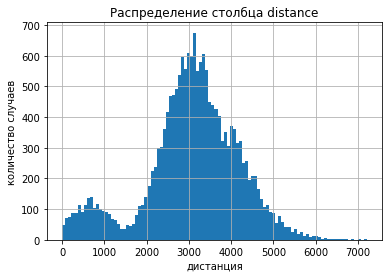

In [34]:
# Визуализируем распределение
rides_df['distance'].hist(bins=100)
plt.title('Распределение столбца distance')
plt.xlabel('дистанция')
plt.ylabel('количество случаев')
plt.show()

На графике виден второй аномальный пик в районе 700 метров. Посмотрим поближе. 

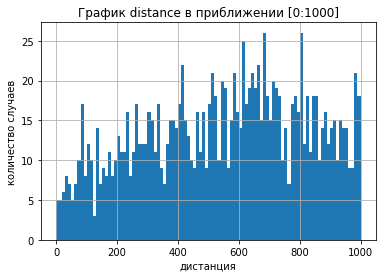

In [35]:
# Визуализируем распределение до 1000
rides_df['distance'].hist(bins=100, range=(0, 1000))
plt.title('График distance в приближении [0:1000]')
plt.xlabel('дистанция')
plt.ylabel('количество случаев')
plt.show()

Возможно этот второй пик связан с подписчками приложения, так как у них бесплатный старт, они могут себе позволить ездить на небольшие расстояния платя только за минуты. \
Но большое количество поездок до 200 метров вызывает вопросы. Можно предположить, что подобные ситуации связаны с тем, тестовыми поездками, либо с дефектом самоката, который клиент менял после того, как проехал небольшое расстояние. Посмотрим на клиентов, которые совершали короткие поездки.

In [36]:
user_id = rides_df.query('distance < 200')['user_id'].unique()
user_id

array([ 707,  711,  712,  713,  720,  721,  724,  732,  734,  739,  752,
        758,  760,  762,  771,  775,  779,  783,  784,  796,  832,  835,
        838,  860,  861,  867,  880,  884,  890,  896,  909,  910,  915,
        918,  925,  936,  943,  949,  950,  952,  955,  962,  967,  971,
        977,  979,  982,  998, 1004, 1008, 1020, 1024, 1026, 1040, 1047,
       1058, 1062, 1069, 1070, 1071, 1077, 1087, 1091, 1095, 1096, 1103,
       1109, 1110, 1112, 1124, 1136, 1139, 1143, 1149, 1157, 1161, 1162,
       1169, 1171, 1185, 1197, 1198, 1207, 1209, 1210, 1213, 1216, 1219,
       1221, 1223, 1225, 1235, 1236, 1237, 1238, 1240, 1241, 1250, 1251,
       1255, 1256, 1258, 1271, 1276, 1279, 1282, 1284, 1285, 1293, 1297,
       1298, 1300, 1303, 1307, 1308, 1310, 1313, 1315, 1316, 1317, 1323,
       1325, 1327, 1328, 1346, 1351, 1356, 1358, 1362, 1364, 1381, 1388,
       1394, 1407, 1409, 1417, 1419, 1420, 1421, 1425, 1431, 1446, 1462,
       1471, 1482, 1489, 1495, 1506, 1508, 1510, 15

In [37]:
rides_df.query('user_id in @user_id').head(50)

,user_id,distance,duration,date,month
6601,707,4645.861650,17.670532,2021-01-03,1
6602,707,3211.571573,25.043393,2021-01-03,1
6603,707,3901.574365,26.630904,2021-03-11,3
6604,707,2434.457205,21.129215,2021-03-13,3
6605,707,1908.824449,11.241832,2021-05-05,5
6606,707,2312.475653,16.937427,2021-05-12,5
6607,707,2675.294778,17.350590,2021-05-18,5
6608,707,2561.678649,19.986396,2021-07-16,7
6609,707,3223.172899,17.408277,2021-08-05,8
6610,707,2047.140570,15.188562,2021-08-09,8


Короткие поездки по одной в день, т.е. версию с поломкой самоката можно отвергнуть. Были совершены в разное время года, у клиентов с разным количеством поездок, к тому же занимали довольно много времени для такой короткой поездки. Может быть много новых клиентов с одной тестовой короткой поездкой?

In [38]:
# Проверим количество поездок у клиентов, имевших опыт короткой поездки
rides_df.query('user_id in @user_id').groupby(by='user_id')['duration'].count().sort_values()

user_id
1495     5
1139     7
1297     7
1482     8
796      8
        ..
1421    22
734     22
1149    23
783     26
1236    27
Name: duration, Length: 158, dtype: int64

In [39]:
# Посмотрим среднюю продолжительность поездки на дистанцию до 200 м.
rides_df.query('distance < 200')['duration'].mean()

8.178881417650405

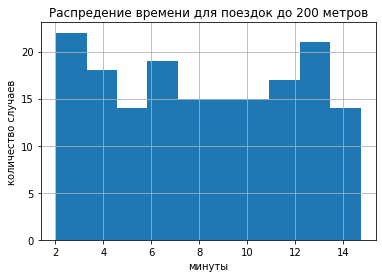

In [40]:
# Посмотрим распределение по времени
rides_df.query('distance < 200')['duration'].hist()
plt.title('Распредение времени для поездок до 200 метров')
plt.xlabel('минуты')
plt.ylabel('количество случаев')
plt.show()

Много аномально долгих коротких поездок. Может быть много клиентов совершающих только короткие поездки? 

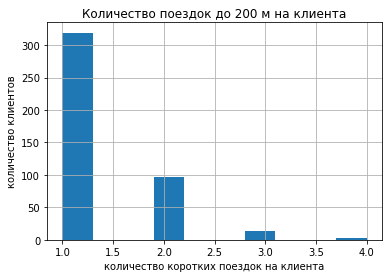

In [41]:
# Уточним, какое количество коротких поездок совершил каждый клиент, построим гистограмму
rides_df.query('distance < 500')['user_id'].value_counts().hist()
plt.title('Количество поездок до 200 м на клиента')
plt.xlabel('количество коротких поездок на клиента')
plt.ylabel('количество клиентов')
plt.show()

Никаких закономерностей у коротких поездок не найдено. Они совершены разными клиентами, в разное время года, на одного клиента чуть больше одного случая.

Что характерно, короткие поездки были у клиентов с user_id от 700 и более, в каждой сотне, вплоть до последней. У клиентов с более ранним порядковым номером id таких случаев не было. 

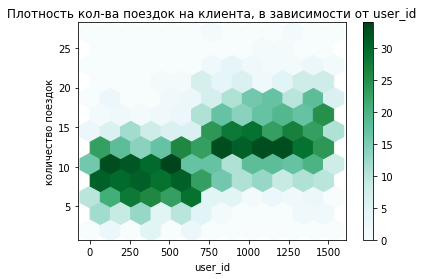

In [42]:
# Посмотрим количество поездок у клиентов с разным user_id
(
    rides_df.pivot_table(index='user_id', values='distance', aggfunc='count')
            .reset_index()
            .plot(legend=False, x='user_id', y='distance', kind='hexbin', sharex=False, gridsize=12)
)
plt.title('Плотность кол-ва поездок на клиента, в зависимости от user_id')
plt.ylabel('количество поездок')
plt.show()

In [43]:
# Выведем среднее количество поездок для клиентов с user_id меньше 700
(
    rides_df.loc[rides_df['user_id'] >= 700, ['user_id', 'distance']]
        .pivot_table(index='user_id', values='distance', aggfunc='count')
        .mean()
)

distance    13.853892
dtype: float64

In [44]:
# Выведем среднее количество поездок для клиентов с user_id меньше 700
(
    rides_df.loc[rides_df['user_id'] < 700, ['user_id', 'distance']]
        .pivot_table(index='user_id', values='distance', aggfunc='count')
        .mean()
)

distance    9.298999
dtype: float64

У клиентов с user_id более 700 в среднем на 4 поездки больше. Возможно это клиенты с подпиской и без, с помощью таблицы users_df проверим этот момент. Это важно, так как нам нужно понимать, это ошибка данных или нет.

In [45]:
# Выведем пограничное число user_id.
users_df.query('user_id > 690 and user_id < 710')

,user_id,name,age,city,subscription_type
690,691,Сергей,30,Сочи,ultra
691,692,Денис,21,Сочи,ultra
692,693,Ксения,20,Омск,ultra
693,694,Алия,29,Краснодар,ultra
694,695,Злата,14,Тюмень,ultra
695,696,Игорь,24,Москва,ultra
696,697,Ясмина,24,Москва,ultra
697,698,Егор,26,Пятигорск,ultra
698,699,Оксана,22,Москва,ultra
699,700,Айдар,22,Омск,free


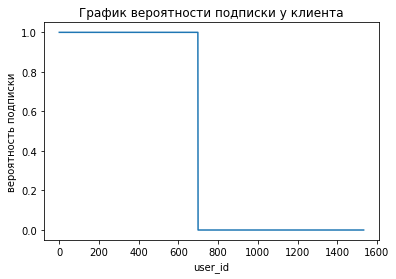

In [46]:
# Посмотрим распределение на графике
p = []

for sub in users_df['subscription_type']:
    if sub == 'free':
        p.append(0)
    else:
        p.append(1)
plt.plot((range(len(p))), p)
plt.title('График вероятности подписки у клиента')
plt.xlabel('user_id')
plt.ylabel('вероятность подписки')
plt.show()

Действительно, с 700 user_id начинаются клиенты без подписки. Но то, что долгие по времени, но короткие по дистанции поездки, совершали клеинты без подписки - удивляет. Оставим данные в этом столбце без изменений, они пригодятся нам для дальнейшего анализа.

In [47]:
# Посмотрим процент сохраненных данных
rides_df.shape[0] / rides_df_old[0] * 100

100.0

### Вывод

В ходе работы мы привели к формату datetime столбец 'date' в таблице rides_df, а также на его основании создали новый столбец 'month' с месяцем, когда пользователем была совершена поездка.

Обнаружили и постарались исправить проблемы в данных:
- в таблице users_df есть дубликаты строк;
- в таблице rides_df в столбце duration есть значения заполненные константными значениями ('0.5');

На данные проблемы необходимо обратить внимание программистов. \
Нам удалось сохранить 100% данных.

## Исследовательский анализ данных

В этом разделе мы опишем и визуализируем общую информацию о пользователях и поездках:
- частота встречаемости городов;
- соотношение пользователей с подпиской и без подписки;
- возраст пользователей;
- расстояние, которое пользователь преодолел за одну поездку;
- продолжительность поездок.

В конце раздела составим портрет типичного пользователя.

### Частота встречаемости городов

Города - категориальная переменная. Выведем в процентах встречаемость каждого города в датафрейме.

In [48]:
# Выведем в процентах частоту встречаемости городов в таблице users_df.
users_df['city'].value_counts() / len(users_df) * 100

Пятигорск         14.276402
Екатеринбург      13.298566
Ростов-на-Дону    12.907432
Краснодар         12.581486
Сочи              12.320730
Омск              11.929596
Тюмень            11.734029
Москва            10.951760
Name: city, dtype: float64

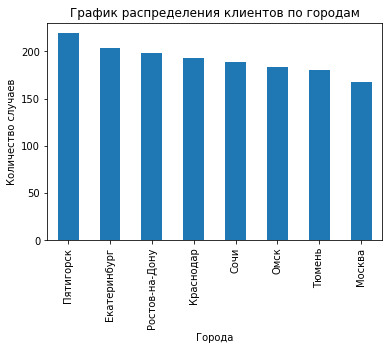

In [49]:
# Визуализируем распределение по городам
users_df['city'].value_counts().plot.bar()
plt.title('График распределения клиентов по городам')
plt.xlabel('Города')
plt.ylabel('Количество случаев')
plt.show()

Самое большое количество пользователей зарегистрировано в Пятигорске. \
Самое меньшее - в Москве, что удивительно, так как Москва самый большой и туристический город России. Видимо велика конкуренция или это новое направление.

### Соотношение пользователей с подпиской и без подписки.

Подписка - категориальная переменная. Также выведем процент пользовтелей с подпиской и без, от общего количества записей в датафрейме.

In [50]:
# Посмотрим количество пользователей с подпиской и без.
users_df['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

In [51]:
# Выведем в процентах соотношение пользователей с подпиской и без.
users_df['subscription_type'].value_counts() / len(users_df) * 100

free     54.432855
ultra    45.567145
Name: subscription_type, dtype: float64

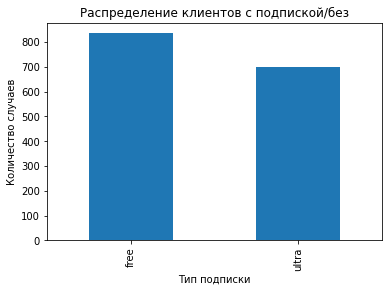

In [52]:
# Визуализируем соотношение пользователей с подпиской и без
users_df['subscription_type'].value_counts().plot.bar()
plt.title('Распределение клиентов с подпиской/без')
plt.xlabel('Тип подписки')
plt.ylabel('Количество случаев')
plt.show()

Пользователей без подписки на 4.5 % больше, чем пользователей с подпиской. \
Всего в датафрейме 699 пользователей с подпиской и 835 пользователей без подписки.

### Возраст пользователей

Возраст в данном случае, в этой таблице - категориальная переменнная, так как принимает только целые значения. Посмотрим диапазон возрастов клиентов, которые пользуются нашим сервисом.

In [53]:
# Отсортируем датафрейм по возрасту и выведем на экран
users_df['age'].sort_values()

664     12
66      12
727     12
34      12
235     13
        ..
383     38
804     38
453     38
961     39
1201    43
Name: age, Length: 1534, dtype: int64

In [54]:
# Посмотрим основные статистики и распределение
users_df.describe()

,user_id,age
count,1534.000000,1534.000000
mean,767.500000,24.903520
std,442.971971,4.572367
min,1.000000,12.000000
25%,384.250000,22.000000
50%,767.500000,25.000000
75%,1150.750000,28.000000
max,1534.000000,43.000000


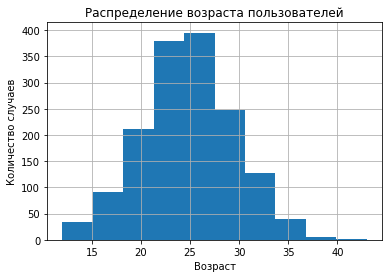

In [55]:
# Визуализируем распределение
users_df['age'].sort_values().hist()
plt.title('Распределение возраста пользователей')
plt.xlabel('Возраст')
plt.ylabel('Количество случаев')
plt.show()

 Нашим сервисом пользуются клиенты от 12 до 43 лет включительно. Посмотрим процент пользователей каждого возраста от всего датасета.

In [56]:
# Выведем в процентах соотношение пользователей с подпиской и без.
users_df['age'].value_counts(normalize=True) * 100

25    9.452412
24    8.604954
26    8.539765
23    8.409387
27    7.757497
22    7.757497
28    7.301173
21    6.062581
20    4.628422
30    4.432855
29    4.432855
31    3.129074
19    3.063885
18    2.998696
32    2.672751
33    2.542373
17    1.694915
34    1.238592
16    1.238592
35    0.977836
15    0.847458
14    0.586701
13    0.521512
36    0.391134
12    0.260756
38    0.195567
37    0.130378
39    0.065189
43    0.065189
Name: age, dtype: float64

Для удобства восприятия, категоризируем возраста и выведем их количество и процент от общего датафрейма.

In [57]:
# Категоризируем возраста
children_count = 0
to_23 = 0
to_30 = 0
over_30 = 0

for age in users_df['age']:
    if age < 18:
        children_count += 1
    elif age < 23:
        to_23 += 1
    elif age < 30:
        to_30 += 1
    else:
        over_30 += 1

# Выведем на экран количество
print(f'Пользователей до 18 лет:        {children_count}.'
      f'\nПользователей от 18 до 23 лет: {to_23}.'
      f'\nПользователей от 23 до 30 лет: {to_30}.'
      f'\nПользователей от 30 и старше:       {over_30}.')

Пользователей до 18 лет:        79.
Пользователей от 18 до 23 лет: 376.
Пользователей от 23 до 30 лет: 836.
Пользователей от 30 и старше:       243.


In [58]:
# Выведем возраста пользователей в процентах
amount_users = len(users_df)
print(f'Пользователей до 18 лет:        {round(children_count / amount_users * 100, 2)} % от общего количества.'
      f'\nПользователей от 18 до 23 лет: {round(to_23 / amount_users * 100, 2)} % от общего количества.'
      f'\nПользователей от 23 до 30 лет: {round(to_30 / amount_users * 100, 2)} % от общего количества.'
      f'\nПользователей от 30 и старше:       {round(over_30 / amount_users * 100, 2)} % от общего количества.')

Пользователей до 18 лет:        5.15 % от общего количества.
Пользователей от 18 до 23 лет: 24.51 % от общего количества.
Пользователей от 23 до 30 лет: 54.5 % от общего количества.
Пользователей от 30 и старше:       15.84 % от общего количества.


Основные пользователи нашего приложения - молодые люди от 23 до 29 лет включительно, таких более половины. На втором месте пользователи от 18 до 23 лет. \
Самый часто встречающийся возраст - 25 лет. Далее идут 24, 26 и 23 года. 

### Расстояние, которое пользователь преодолел за одну поездку.

Расстояние - непрерывная величина. Посмотрим какое в среднем расстояние преодалевали пользователи за одну поездку. Также посмотрим какое в среднем расстояние преодолевает пользователи с подпиской и без подписки.

In [59]:
# Посмотрим основные статистики
rides_df['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Минимум на 85 сантиметрах, максимум 7.2 км. Довольно высокое стандартное отклонение, значит значения распределены в широком диапазоне.

In [60]:
# Посмотрим среднюю дистанцию поездки по всем клиентам
rides_df['distance'].mean()

3070.6599756818814

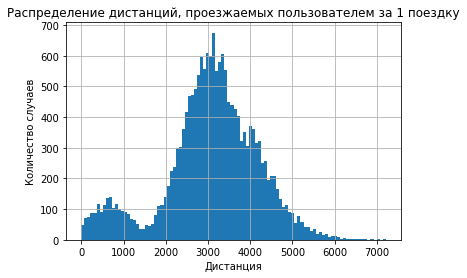

In [61]:
# Визуализируем распределение
rides_df['distance'].hist(bins=100)
plt.title('Распределение дистанций, проезжаемых пользователем за 1 поездку')
plt.xlabel('Дистанция')
plt.ylabel('Количество случаев')
plt.show()

Видим два пика, один в районе 3200 метров и второй в районе 700 метров. Интересна природа появления пика на 700 метрах, мы ранее выявили много коротких по дистанции, но длинных по времени поездок, но они занимали малую долю этих случаев. 

Для определения клиентов с подпиской и без в датафрейме rides_df, выгрузим из таблицы users_df id пользователей с подпиской и без.

In [62]:
# Выгрузим в переменные id
users_free_subscription = users_df.query('subscription_type == "free"')['user_id']
users_ultra_subscription = users_df.query('subscription_type == "ultra"')['user_id']

In [63]:
# Определим среднюю дистанцию поезки у пользователей без подписки
rides_df.query('user_id in @users_free_subscription')['distance'].mean()

3045.495281671816

In [64]:
# Определим среднюю дистанцию поезки у пользователей без подписки
rides_df.query('user_id in @users_ultra_subscription')['distance'].mean()

3115.4453880370247

В целом, среднее расстояние, которое преодолевают пользователи с подпиской и без почти равно. \
У пользователей без подписки оно составляет 3045 метров, у пользователей с подпиской - 3115 метров. 

Средняя продолжительность поездки в целом составила 3070 метров.

### Продолжительность поездок.

Анологичным образор рассчитаем продолжительность поездок клиентов: найдем среднюю длительность поездки клиента, а также дополнительно посмотрим этот показатель по группам клиентов с подпиской и без. 

In [65]:
# Посмотрим основные статистики
rides_df['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Минимальное время поездки - половина минуты, мы ранее выявили эту аномалию, короткие по времени, но длинные по дистанции поездки. Максимальное время - 40.8 минут. Довольно большое стандартные отклонение, значит данные распределены неравномерно, в широком диапазоне.

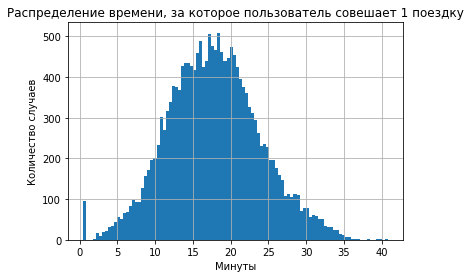

In [66]:
# Визуализируем распределение
rides_df['duration'].hist(bins=100)
plt.title('Распределение времени, за которое пользователь совешает 1 поездку')
plt.xlabel('Минуты')
plt.ylabel('Количество случаев')
plt.show()

Видим ранее выявленный аномальный выброс в районе 1 минуты - это много случаев коротких по времени, но длинных по дистанции поездок. Отметим также, что на графике отсутствует первый пик, это значит, что короткие поездки, которые составляли малый пик на графике дистанций, были массово долгими по времени, это странно, необходимо выяснить природу данного феномена.

In [67]:
# Определим среднюю продолжительность поездки
rides_df['duration'].mean()

17.80501119798444

In [68]:
# Определим среднюю продолжительность поезки у пользователей без подписки
rides_df.query('user_id in @users_free_subscription')['duration'].mean()

17.39090929866399

In [69]:
# Определим среднюю продолжительность поезки у пользователей без подписки
rides_df.query('user_id in @users_ultra_subscription')['duration'].mean()

18.54198516280583

 Средняя продолжительность поездки пользователей - 17.8 минут. \
 У пользователей без подписки - 17.4 минуты. \
 У пользователей с подпиской - 18.5 минут.

### Вывод.

Самое большое количество пользователей зарегистрировано в Пятигорске. \
Самое меньшее - в Москве, что удивительно, так как Москва самый большой и туристический город России. Видимо велика конкуренция или это новое направление. \
\
Пользователей без подписки на 4.5 % больше, чем пользователей с подпиской. \
Всего в датафрейме 699 пользователей с подпиской и 835 пользователей без подписки. \
\
Основные пользователи нашего приложения - молодые люди от 23 до 30 лет, таких более половины. На втором месте пользователи от 18 до 23 лет. \
Самый часто встречающийся возраст - 25 лет. Далее идут 24, 26 и 23 года. \
\
В целом, среднее расстояние, которое преодолевают пользователи с подпиской и без почти равно. \
У пользователей без подписки оно составляет 3045 метра, у пользователей с подпиской - 3115 метров. \
Средняя продолжительность поездки в целом составляет 3070 метров. \
\
Средняя продолжительность поездки пользователей - 17.8 минут. \
У пользователей без подписки - 17.4 минуты. \
У пользователей с подпиской - 18.5 минут.

Составим портрет типичного пользователя: он из Пятигорска, ему 25 лет и он пользуется сервисом без подписки, проезжает на самокате 3 километра, и тратит на это 18 минут.



## Объединение данных

В этом разделе мы объединим все датафреймы в один, потом на основании этого датафрейма создадим два: с данными пользователей с подпиской и данными пользователей без подписки. \
Далее визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

### Объединим датафреймы в один

In [70]:
# Объединим датафреймы
data = rides_df.merge(users_df, on='user_id', how='left').merge(subscriptions_df, on='subscription_type', how='left')

# Оценим результат
data.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199


In [71]:
# Проверим корректность результата
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


### Разделим датафрейм на два: с данными пользователей с подпиской и данными пользоваталей, которые пользуются тарифом без подписки.

In [72]:
# Сформируем датафреймы
df_clients_free = data.query('subscription_type == "free"').reset_index(drop=True)
df_clients_ultra = data.query('subscription_type == "ultra"').reset_index(drop=True)

# Посмотрим на результат
display(df_clients_free)
df_clients_ultra

,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,700,2515.690719,14.944286,2021-01-02,1,Айдар,22,Омск,free,8,50,0
1,700,846.932642,16.234663,2021-02-01,2,Айдар,22,Омск,free,8,50,0
2,700,4004.434142,20.016628,2021-02-04,2,Айдар,22,Омск,free,8,50,0
3,700,1205.911290,9.782872,2021-02-10,2,Айдар,22,Омск,free,8,50,0
4,700,3047.379435,17.427673,2021-02-14,2,Айдар,22,Омск,free,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11563,1534,3781.098080,19.822962,2021-11-04,11,Альберт,25,Краснодар,free,8,50,0
11564,1534,2840.423057,21.409799,2021-11-16,11,Альберт,25,Краснодар,free,8,50,0
11565,1534,3826.185507,18.435051,2021-11-18,11,Альберт,25,Краснодар,free,8,50,0
11566,1534,2902.308661,16.674362,2021-11-27,11,Альберт,25,Краснодар,free,8,50,0


,user_id,distance,duration,date,month,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,4409.919140,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,6,0,199
1,1,2617.592153,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,6,0,199
2,1,754.159807,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,6,0,199
3,1,2694.783254,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,6,0,199
4,1,4028.687306,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,3973.046497,24.671163,2021-08-29,8,Оксана,22,Москва,ultra,6,0,199
6496,699,3288.702563,15.892886,2021-09-12,9,Оксана,22,Москва,ultra,6,0,199
6497,699,3076.159348,14.389525,2021-09-26,9,Оксана,22,Москва,ultra,6,0,199
6498,699,4707.845501,15.839579,2021-10-17,10,Оксана,22,Москва,ultra,6,0,199


In [73]:
# Посмотрим на информацию по датафреймам
print(df_clients_free.info(), '\n')

df_clients_ultra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11568 entries, 0 to 11567
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   distance           11568 non-null  float64       
 2   duration           11568 non-null  float64       
 3   date               11568 non-null  datetime64[ns]
 4   month              11568 non-null  int64         
 5   name               11568 non-null  object        
 6   age                11568 non-null  int64         
 7   city               11568 non-null  object        
 8   subscription_type  11568 non-null  object        
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.1+ MB
None 

<class 'pandas.core.frame.DataFra

### Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий.

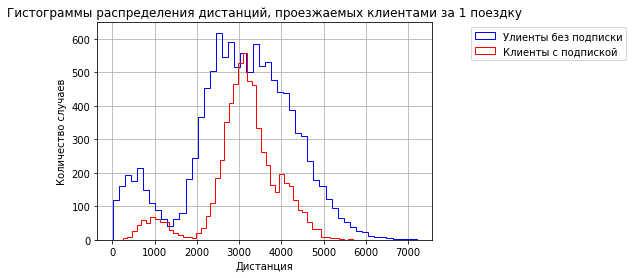

In [74]:
# Построим графики
df_clients_free['distance'].sort_values().plot(
    kind='hist',
    label='Улиенты без подписки',
    histtype='step',
    bins=50,
    color='b'
)
df_clients_ultra['distance'].sort_values().plot(
    kind='hist',
    label='Клиенты с подпиской',
    histtype='step',
    bins=50,
    color='r'
)
plt.legend(bbox_to_anchor=(1.1, 1.00))
plt.title('Гистограммы распределения дистанций, проезжаемых клиентами за 1 поездку')
plt.xlabel('Дистанция')
plt.ylabel('Количество случаев')
plt.grid()
plt.show()

Видно, что клиенты без подписки совершают больше коротких по дистанции поездок, несмотря на то, что такие поездки более выгодны клиентам с подпиской, так как у них бесплатный старт. Клиенты без подписки совершали много длительных поездок - более 3130 метров, практически все самые длинные поездки (более 5600 метров, которые посчитались как выбросы) совершали именно клиенты без подписки. 

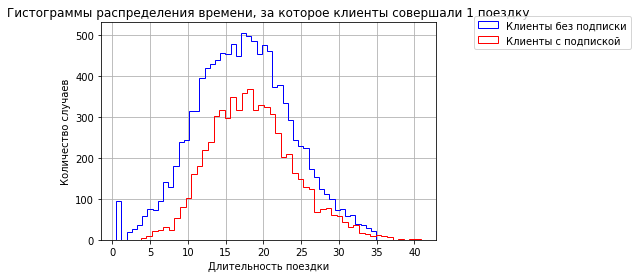

In [75]:
# Построим графики
df_clients_free['duration'].sort_values().plot(
    kind='hist',
    label='Клиенты без подписки',
    histtype='step',
    bins=50,
    color='b'
)
df_clients_ultra['duration'].sort_values().plot(
    kind='hist',
    label='Клиенты с подпиской',
    histtype='step',
    bins=50,
    color='r'
)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Гистограммы распределения времени, за которое клиенты совершали 1 поездку')
plt.xlabel('Длительность поездки')
plt.ylabel('Количество случаев')
plt.grid()
plt.show()

Видно, что все поездки с коротким временем (0.5 минуты, выявленные ранее), но длинные по дистанции поездки, совершили клиенты без подписки. Также клеинты с подпиской совершили больше более длительных поездок (графики стремится к пересечению синей в правом хвосте, после чего синяя линия вовсе заканчивается).

Стоит отметить, что пользователи без подписки совершали больше поездок, чем пользователи с подпиской. А именно:

In [76]:
# Уточним, на сколько поездок больше совершал пользователь без подписки
(
    len(df_clients_free) / len(df_clients_free['user_id'].unique()) -
    len(df_clients_ultra) / len(df_clients_ultra['user_id'].unique())
)

4.554893646184027

В среднем на 4.6 поездки больше совершал пользователь без подписки.

В целом, графики совпадают. Отдельно стоит отметить большое количество коротких по дистанции, но долгих по времени поездок у пользователей без подписки, это видно по отсутствию даже намека на первый пик в графике времени поездки. Непонятный феномен. Также по графикам мы поняли, что клиенты с подпиской проезжают меньшие расстояния за более длительное время, чем клиенты без подписки.

### Вывод

Мы совместили все три таблицы и сделали на ее основании два дополнительных датафрейма: со всей информацией о пользователях с подпиской и без подписки. Далее визуализировали дистанцию и длительность поездок у пользователей обеих страт. В целом, графики совпадают. Отдельно стоит отметить большое количество коротких по дистанции, но долгих по времени поездок у пользователей без подписки, это видно по отсутствию даже намека на первый пик в графике времени поездки. Непонятный феномен.

## Подсчёт выручки

В этом разделе мы посчитаем помесячную выручку, которую принес каждый пользователь. Для этого мы, на основе датафрейма с объединёнными данными, создадим датафрейм с агрегированными данными о поездках, найдем суммарное расстояние, количество и суммарное время поездок для каждого пользователя за каждый месяц. В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь.

In [77]:
# Округлим количество минут продолжительности поездок в большую сторону
data['duration'] = np.ceil(data['duration'])

# Создадим датафрей с агрегированными данными о поездках
agg_data = data.groupby(by=['user_id', 'month']).agg({
    'distance': 'sum', 
    'duration' :['sum', 'count'], 
    'subscription_type': 'first', 
    'minute_price': 'first', 
    'start_ride_price': 'first', 
    'subscription_fee': 'first'
})

# Перезапишем индексы
agg_data = agg_data.reset_index()

# Уберем двойные названия столбцов
agg_data.columns = ['user_id', 'month', 'sum_distance', 'sum_duration', 
                    'count_rides', 'subscription_type', 'minute_price', 
                    'start_ride_price', 'subscription_fee']

# Оценим результат
agg_data.head()

,user_id,month,sum_distance,sum_duration,count_rides,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,7027.511294,42.0,2,ultra,6,0,199
1,1,4,754.159807,7.0,1,ultra,6,0,199
2,1,8,6723.470560,46.0,2,ultra,6,0,199
3,1,10,5809.911100,32.0,2,ultra,6,0,199
4,1,11,7003.499363,56.0,3,ultra,6,0,199


In [78]:
# Создадим функцию для подсчета формулы выручки
def calculate_monthly_revenue(row):
    if row.isna().sum() > 0:
        return print('Ошибка. В сводной таблице есть пропуски.')
    return row['start_ride_price'] * row['count_rides'] + row['minute_price'] * row['sum_duration'] + row['subscription_fee']

# Создадим новую колонку с подсчетом выручки за месяц 
agg_data['monthly_revenue'] = agg_data.apply(calculate_monthly_revenue, axis=1)

# Проверим корректность подсчета и создания колонки
agg_data

,user_id,month,sum_distance,sum_duration,count_rides,subscription_type,minute_price,start_ride_price,subscription_fee,monthly_revenue
0,1,1,7027.511294,42.0,2,ultra,6,0,199,451.0
1,1,4,754.159807,7.0,1,ultra,6,0,199,241.0
2,1,8,6723.470560,46.0,2,ultra,6,0,199,475.0
3,1,10,5809.911100,32.0,2,ultra,6,0,199,391.0
4,1,11,7003.499363,56.0,3,ultra,6,0,199,535.0
...,...,...,...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,26.0,2,free,8,50,0,308.0
11327,1534,8,7622.453034,48.0,2,free,8,50,0,484.0
11328,1534,9,4928.173852,23.0,1,free,8,50,0,234.0
11329,1534,11,13350.015305,78.0,4,free,8,50,0,824.0


In [79]:
# Посмотрим среднюю месячкую выручку с клиента без подписки
agg_data.query('subscription_type == "free"')['monthly_revenue'].mean()

328.6413651073845

In [80]:
# Посмотрим среднюю месячную выручку с клиента с подпиской
agg_data.query('subscription_type == "ultra"')['monthly_revenue'].mean()

362.7921906022502

Мы, на основе датафрейма с объединёнными данными, создали датафрейм с агрегированными данными о поездках, нашли суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц. В этот же датафрейм добавили столбец с помесячной выручкой, которую принёс каждый пользователь.

## Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить несколько важных моментов.
1) Важно понять, тратят ли пользователи с подпиской больше времени на поездки? 
2) Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 
3) Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

В качестве четвертого задания, ответим на вопрос: "Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?"

### Тратят ли пользователи с подпиской больше времени на поездки.

Сформулируем нулевую и альтернативную гипотезы:
- H0 : среднее время, которое тратят на поездки пользователи с подпиской, равно среднему времени, которое тратят на поездки пользователи без подписки;
- H1 : среднее время, которое тратят на поездки пользователи с подпиской, больше, чем среднее время, которое тратят на поездки пользователи без подписки.

Проверим эти гипотезы. \
Проверим нулевую гипотезу о равенстве разности между двумя средними нулю. \
Будем использовать метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: scipy.stats.ttest_ind(array1, array2, equal_var, alternative) \
В качестве двух выборок у нас будет выступать один датасет, отфильтрованный по группам пользователей, а так как выборки будут разного размера, параметр equal_var изменим на False.

Проверим одностороннюю альтернативную гипотезу: для этого укажем правый вариант в параметре alternative - 'greater'.

In [81]:
# сформируем выборки - подмножества
subscription_type_ultra = rides_df.query('user_id in @users_ultra_subscription')['duration']
subscription_type_free = rides_df.query('user_id in @users_free_subscription')['duration']
print(f'Средняя время поездки пользователей с подпиской {subscription_type_ultra.mean()}')
print(f'Средняя время поездки пользователей без подписки {subscription_type_free.mean()}')

# так как у нас не требующее большой точности биомедицинское исследование, зададим уровень статистической значимости 5%
alpha = 0.05

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(subscription_type_ultra, subscription_type_free, equal_var=False, alternative='greater')

print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

Средняя время поездки пользователей с подпиской 18.54198516280583
Средняя время поездки пользователей без подписки 17.39090929866399
p-value: 5.6757813771289775e-37
Отвергаем нулевую гипотезу


С помощью среднего выборки мы смогли оценить генеральную совокупность, мы выяснили, что пользователи с подпиской в среднем тратят больше времени на поездки, чем пользователи без подписки.

### Расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.


    Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

Сформулируем нулевую и альтернативную гипотезы: \
H0 : Расстояние, которое проезжают пользователи с подпиской за одну поездку равно оптимальному расстоянию - 3130 метров. \
H1 : Расстояние, которое проезжают пользователи с подпиской за одну поездку больше оптимельного. 

Проверим гипотезы с помощью метода scipy.stats.ttest_1samp(a, popmean, alternative).
Альтернативная гипотеза правосторонняя, поэтому аргументу alternative мы передадим параметр 'greater'

In [82]:
subscription_type_ultra = rides_df.query('user_id in @users_ultra_subscription')['distance']

# так как у нас не требующее большой точности биомедицинское исследование, зададим уровень статистической значимости 5%
alpha = 0.05

# выберем предпологаемое среднее
ideal_distance = 3130

result = st.ttest_1samp(subscription_type_ultra, ideal_distance, alternative='greater')

print(f'Средняя расстояние, которое проезжают пользователи с подпиской {subscription_type_ultra.mean()}')
print(f'p-value: {results.pvalue}')

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

Средняя расстояние, которое проезжают пользователи с подпиской 3115.4453880370247
p-value: 5.6757813771289775e-37
Нет оснований отвергнуть нулевую гипотезу


С помощью среднего выборки мы смогли оценить среднее генеральной совокупности, мы выяснили, что пользователи с подпиской, в среднем за одну поезку, проезжают расстояние не превышающее оптимальное с точки зрения износа самоката - 3130 метров.

### Помесячная выручка от пользователей с подпиской выше, чем по пользователям без подписки.

Сформируем нулевую и альтернативную гипотезы: \
Н0 : Помесячная выручка от пользователей с подпиской по месяцам равна выручке от пользователей без подписки. \
Н1 : Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

Проверим нулевую гипотезу о равенстве разности между двумя средними нулю. \
Будем использовать метод для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: scipy.stats.ttest_ind(array1, array2, equal_var, alternative) \
В качестве двух выборок у нас будет выступать один датасет, отфильтрованный по группам пользователей, а так как выборки будут разного размера, параметр equal_var изменим на False.

Проверим одностороннюю альтернативную гипотезу: для этого укажем правый вариант в параметре alternative - 'greater'.

In [83]:
# сформируем выборки - подмножества
subscription_type_ultra = agg_data.query('user_id in @users_ultra_subscription')['monthly_revenue']
subscription_type_free = agg_data.query('user_id in @users_free_subscription')['monthly_revenue']

# так как у нас не требующее большой точности биомедицинское исследование, зададим уровень статистической значимости 5%
alpha = 0.05

# проводим ttest для двух выборок, в качестве альтернативной используем одностороннюю гипотезу «больше»
results = st.ttest_ind(subscription_type_ultra, subscription_type_free, equal_var=False, alternative='greater')

print(f'Средняя помесячная выручка от пользователей с подпиской {subscription_type_ultra.mean()}')
print(f'Средняя помесячная выручка от пользователей без подписки {subscription_type_free.mean()}')
print(f'p-value: {results.pvalue}')

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

Средняя помесячная выручка от пользователей с подпиской 362.7921906022502
Средняя помесячная выручка от пользователей без подписки 328.6413651073845
p-value: 8.874140893976874e-40
Отвергаем нулевую гипотезу


Дополнительно посмотрим, какую долю в общей выручке компании, занимают пользователи с подпиской. 

С помощью среднего выборки мы смогли оценить генеральную совокупность, мы выяснили, что средняя месячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

### Обращения в поддержку уменьшились, после обновления серверов

Задача: "Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?"

Ответ: Здесь мы будем сравнивать две зависимые, парные выборки, поэтому для проверки этого кейса мы бы использовали т-тест Стьюдента, метод scipy.stats.ttest_rel() с аргументами: файлами с количеством обращений до обновления и количеством обращений после обновления, а также, так как гипотеза левосторонняя, использовали бы аргумент alternative с параметром 'less'.

### Вывод

Мы проверили ряд гипотез и выяснили, что:
- средняя месячная выручка от пользователей с подпиской выше, чем от пользователей без подписки;
- пользователи с подпиской в среднем, за одну поезку, не проезжают растояние большее, чем оптимальное с точки зрения износа самоката расстояние в 3130 метров;
- помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Дополнительно мы выяснили, что в данный момент в общей выручке компании, выручка от пользователй с подпиской сотавляет примерно 42%, в интересах компании увеличивать этот процент.

Также мы ответили, какой бы метод мы исспользовали при проверке гипотезы, в которой проверялось, уменьшилось ли количество обращений в службу поддержки при обновлении серверов.  

## Общий вывод

В ходе аналитического исследования нами было изучено три файла с данными пользователей из нескольких городов и их поездках, в ходе знакомства с данными, мы выяснили, что файлы содержат: \
В файле users_go.csv (выгрузили в переменную users_df):
- 1565 строк и 5 колонок;
- есть 9 выбросов в столбце age и 31 дубликат строк.

В файле rides_go.csv (выгрузили в переменную rises_df):
- 18068  строк и 4 колонки;
- есть значительное количество выбросов(1036) в столбце distance и 177 в столбце duration. 

В файле subscriptions_go.csv (выгрузили в переменную subscriptions_df) всего две строки - тарифы, 4 колонки, проблем нет. 

Необходимо выявить причины появления дубликатов строк в файле users_go.csv, советуем обратить внимание программистов на эту проблему. 
В таблицах rides_df столбцец data привести к типу данных datetime.

В ходе предобработки данных мы привели к формату datetime столбец 'date' в таблице rides_df, а также на его основании создали новый столбец 'month' с месяцем, когда пользователем была совершена поездка.

Обнаружили и постарались исправить проблемы в данных:
- в таблице users_df есть дубликаты строк;
- в таблице rides_df в столбце duration есть значения заполненные константными значениями ('0.5');

На данные проблемы необходимо обратить внимание программистов. \
Нам удалось сохранить более 99% данных.


В ходе исследовательского анализа данных, мы выяснили: \

Самое большое количество пользователей зарегистрировано в Пятигорске. \
Самое меньшее - в Москве, что удивительно, так как Москва самый большой и туристический город России. Видимо велика конкуренция или это новое направление. \
\
Пользователей без подписки на 4.5 % больше, чем пользователей с подпиской. \
Всего в датафрейме 699 пользователей с подпиской и 835 пользователей без подписки. \
\
Основные пользователи нашего приложения - молодые люди от 23 до 30 лет, таких более половины. На втором месте пользователи от 18 до 23 лет. \
Самый часто встречающийся возраст - 25 лет. Далее идут 24, 26 и 23 года. \
\
В целом, среднее расстояние, которое преодолевают пользователи с подпиской и без почти равно. \
У пользователей без подписки оно составляет 3045 метра, у пользователей с подпиской - 3115 метров. \
Средняя продолжительность поездки в целом составляет 3070 метров. \
\
Средняя продолжительность поездки пользователей - 17.8 минут. \
У пользователей без подписки - 17.4 минуты. \
У пользователей с подпиской - 18.5 минут.

Составим портрет типичного пользователя: он из Пятигорска, ему 25 лет и он пользуется сервисом без подписки, проезжает на самокате 3 километра, и тратит на это 18 минут.

На этапе объединения таблиц, мы совместили все три таблицы и сделали на ее основании два дополнительных датафрейма: со всей информацией о пользователях с подпиской и без подписки. Далее визуализировали дистанцию и длительность поездок у пользователей обеих страт. В целом, графики совпадают. Отдельно стоит отметить большое количество коротких по дистанции, но долгих по времени поездок у пользователей без подписки, это видно по отсутствию даже намека на первый пик в графике времени поездки. Непонятный феномен.

Мы проверили ряд гипотез и выяснили, что:
- пользователи с подпиской в среднем тратят больше времени на поездки, чем пользователи без подписки;
- пользователи с подпиской в среднем, за одну поезку, не проезжают растояние большее, чем оптимальное с точки зрения износа самоката расстояние в 3130 метров;
- помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

Также мы ответили, какой бы метод мы исспользовали при проверке гипотезы, в которой проверялось, уменьшилось ли количество обращений в службу поддержки при обновлении серверов.  


Таким образом, пользователи с подпиской более выгодны для компании, чем пользователи без подписки: они тратят в месяц больше средств, в среднем проезжают не больше оптимального с точки зрения износа самоката расстояния и тратят больше времени на поездки, чем пользователи без подписки.

